## Introduction
After working with analytical solutions to demonstrate the impact of different reactions on solute transport we have come across some limitiations. What are they?

We will use FloPy in this notebook to expand the complexity of the scenarios that we can model.

Import the standard libraries

In [1]:
# Import the flopy library
import flopy
# Import a few additional libraries
import sys
import os
# In addition to our typical libraries
import numpy as np
import matplotlib.pyplot as plt

flopy is installed in C:\ProgramData\Anaconda3\lib\site-packages\flopy


First find where you have your MODFLOW and MT3D executables located on your system.

In [2]:
# Path to MODFLOW executable, probably called 'mf2005'
exe_name_mf = 'C:\\Hydro\\MF2005.1_12\\MF2005.1_12\\bin\\mf2005'
# Print to make sure it is formated correctly
print(exe_name_mf)
# Path to MT3D executable, probably called 'mt3dms'
exe_name_mt = 'C:\\Hydro\\mt3dusgs1.1.0\\mt3dusgs1.1.0\\bin\\mt3d-usgs_1.1.0_64'
# Print to make sure it is formated correctly
print(exe_name_mt)

C:\Hydro\MF2005.1_12\MF2005.1_12\bin\mf2005
C:\Hydro\mt3dusgs1.1.0\mt3dusgs1.1.0\bin\mt3d-usgs_1.1.0_64


Let's create a new directory to save the data. 

In [3]:
# directory to save data
directory_name = 'reactions_1D_models'
# directory to save data
datadir = os.path.join('..', directory_name, 'mt3d_test', 'mt3dms')
workdir = os.path.join('.', directory_name)

Notice however that we don't yet name the folder where we will save data 'dirname'. This will be an input to our model function.


## 1D Reactions Model Function
The first thing we do is setup the function. The input variables are:

### Function Input:
#### directory name
    direname = 

#### MT3D period length 
Time is in selected units, the model time length is the sum of this (for steady state flow it can be set to anything). Note that this is different from the MODFLOW flow model period input. Therefore the underlying flow conditions are constant and steady state across changes in MT3D stress periods. The format for multi-period input: ```[time_of_pulse_injection, time_of_rest_of_model]```

The function is set up to only allow for two input periods. For example:
 
    perlen_mt = [60, 60*58]
    
    
#### Porosity

    prsity = 
    
#### advection velocity

    v = 
    
#### dispersivity
Set the longitudinal dispersivity in selected units. What are the units again?

    al = 
  
### Reaction model input  
#### Model type
isothm is a flag indicating which type of sorption (or dual-domain mass transfer) is simulated: isothm = 0, no sorption is simulated; isothm = 1, linear isotherm (equilibrium-controlled); isothm = 2, Freundlich isotherm (equilibrium-controlled); isothm = 3, Langmuir isotherm (equilibrium-controlled). While there are addition options for now we will focus on these four models.

    isothm = 

#### bulk density (rhob)
This can be a float or array of floats (nlay, nrow, ncol). rhob is the bulk density of the aquifer medium (unit, ML-3). rhob is used if isothm = 1, 2, 3, 4, or 6. If rhob is not user-specified and isothm is not 5 then rhob is set to 1.8e3. (default is None)


#### First sorption parameter (sp1)
Can be a float or array of floats (nlay, nrow, ncol). The use of sp1 depends on the type of sorption selected (the value of isothm). If sp1 is not specified and isothm > 0 then sp1 is set to 0. (default is None).

For linear sorption (isothm = 1) and nonequilibrium sorption (isothm = 4), sp1 is the distribution coefficient (Kd) (unit, L3M-1). 

For Freundlich sorption (isothm = 2), sp1 is the Freundlich equilibrium constant (Kf) (the unit depends on the Freundlich exponent a). 

For Langmuir sorption (isothm = 3), sp1 is the Langmuir equilibrium constant (Kl) (unit, L3M-1 ). 

For example 
    
    isothm = 1
    sp1 = kd 

Where 
    
    kd = (retardation - 1.) * prsity / rhob

#### Second sorption parameter (sp2)
sp2 can be a float or array of floats (nlay, nrow, ncol). The use of sp2 depends on the type of sorption model selected. 

For linear sorption (isothm = 1), sp2 is read but not used. 

For Freundlich sorption (isothm = 2), sp2 is the Freundlich exponent N. 

For Langmuir sorption (isothm = 3), sp2 is the total concentration of the sorption sites available ( S ) (unit, MM-1).  If sp2 is not specified and isothm > 0 then sp2 is set to 0. (default is None).

For example 
    
    isothm = 2
    sp1 = kf
    sp2 = N


#### Additional Reaction Package input options (not used in this function 
ireact is an integer flag indicating which type of kinetic rate reaction is simulated: ireact = 0, no kinetic rate reaction is simulated

rc1 is the first-order reaction rate for the dissolved (liquid) phase for the first species (unit, T-1). rc1 is not used ireact = 0. 

rc2 is the first-order reaction rate for the sorbed phase for the first species (unit, T-1). rc2 is not used ireact = 0. 

In [40]:
def reaction_model_1D(dirname, perlen_mt, prsity, v, al, isothm, rhob, sp1, sp2):
    # Model workspace and new sub-directory
    model_ws = os.path.join(workdir, dirname)
    print(model_ws)
    
    # time units (itmuni in discretization package), unfortunately this entered differently into MODFLOW and MT3D
    # 1 = seconds, 2 = minutes, 3 = hours, 4 = days, 5 = years
    itmuni = 1 # MODFLOW
    mt_tunit = 'S' # MT3D units
    # length units (lenuniint in discretization package)
    # 0 = undefined, 1 = feet, 2 = meters, 3 = centimeters
    lenuni = 3 # MODFLOW units
    mt_lunit = 'CM' # MT3D units
    
    # Modflow stress periods
    perlen_mf = [np.sum(perlen_mt)]
    # number of stress periods (MF input), calculated from period length input
    nper_mf = len(perlen_mf)
    
    # number of stress periods (MT input), calculated from period length input
    nper = len(perlen_mt)
    
    # Frequency of output, If nprs > 0 results will be saved at 
    #     the times as specified in timprs; 
    nprs = 100
    # timprs (list of float): The total elapsed time at which the simulation 
    #     results are saved. The number of entries in timprs must equal nprs. (default is None).
    timprs = np.linspace(0, np.sum(perlen_mf), nprs, endpoint=False)
    
    # Model information 
    nlay = 1 # number of layers
    nrow = 1 # number of rows
    ncol = 101 # number of columns
    delr = 0.2 # grid size in direction of Lx
    delc = 4.4 # grid size in direction of Ly, this was choosen such that the model has the same cross-sectional area as the column from the dispersion notebook example
    delv = 4.4 # grid size in direction of Lz
    laytyp = 0
    
    # length of model in selected units 
    Lx = (ncol - 1) * delr
    print("Model length is: " + str(Lx + delr) + " (check units of 'lenuni')")
    
    # hydraulic conductivity
    hk = 1.
    # advection velocity (function input)
    # v = 0.014
    # porosity
    prsity = prsity
    # discharge (again in selected units)
    q = v * prsity
    
    # Flow field boundary conditions
    # boundary conditions, <0 = specified head, 0 = no flow, >0 variable head
    ibound = np.ones((nlay, nrow, ncol), dtype=np.int)
    # index the inlet cell
    ibound[0, 0, 0] = -1
    # index the outlet cell
    ibound[0, 0, -1] = -1
    # constant head conditions
    strt = np.zeros((nlay, nrow, ncol), dtype=np.float)
    h1 = q * Lx
    # index the inlet cell
    strt[0, 0, 0] = h1
    
    # Solute transport boundary conditions
    # Concentration at inlet boundary
    C_in = [1.0, 0.0]

    # Boundary conditions: if icbund = 0, the cell is an inactive concentration cell; 
    # If icbund < 0, the cell is a constant-concentration cell; 
    # If icbund > 0, the cell is an active concentration cell where the concentration value will be calculated.
    icbund = np.ones((nlay, nrow, ncol), dtype=np.int)

    # Initial conditions: concentration zero everywhere, except the inlet
    sconc = np.zeros((nlay, nrow, ncol), dtype=np.float)
    
    # MT3D stress period data, note that the indices between 'spd_mt' must exist in 'spd_mf' 
    # This is used as input for the source and sink mixing package
    # Itype is an integer indicating the type of point source, 2=well, 3=drain, -1=constant concentration
    itype = -1
    cwell_info = np.zeros((nrow, 5), dtype=np.float)
    # Nested loop to define every inlet face grid cell as a well
    for row in range(0, nrow):
        cwell_info[row] = [0, row, 0, C_in[0], itype] 
            
    # Second stress period        
    cwell_info2 = cwell_info.copy()   
    cwell_info2[:,3] = C_in[1] 
    # Now apply stress period info    
    spd_mt = {0:cwell_info, 1:cwell_info2}
    
    
    # Setup models
    # MODFLOW model name
    modelname_mf = dirname + '_mf'
    # MODFLOW package class
    mf = flopy.modflow.Modflow(modelname=modelname_mf, model_ws=model_ws, exe_name=exe_name_mf)
    # MODFLOW model discretization package class
    dis = flopy.modflow.ModflowDis(mf, nlay=nlay, nrow=nrow, ncol=ncol, nper=nper_mf,
                                   delr=delr, delc=delc, top=0., botm=[0 - delv],
                                   perlen=perlen_mf, itmuni=itmuni, lenuni=lenuni)
    # MODFLOW basic package class
    bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)
    # MODFLOW layer properties flow package class
    lpf = flopy.modflow.ModflowLpf(mf, hk=hk, laytyp=laytyp)
    # MODFLOW preconditioned conjugate-gradient package class
    pcg = flopy.modflow.ModflowPcg(mf)
    # MODFLOW Link-MT3DMS Package Class (this is the package for solute transport)
    lmt = flopy.modflow.ModflowLmt(mf)
    
    mf.write_input()
    mf.run_model(silent=True) # Set this to false to produce output in command window
    
    # RUN MT3dms solute tranport 
    modelname_mt = dirname + '_mt'
    # MT3DMS Model Class
    # Input: modelname = 'string', namefile_ext = 'string' (Extension for the namefile (the default is 'nam'))
    # modflowmodelflopy.modflow.mf.Modflow = This is a flopy Modflow model object upon which this Mt3dms model is based. (the default is None)
    mt = flopy.mt3d.Mt3dms(modelname=modelname_mt, model_ws=model_ws, 
                           exe_name=exe_name_mt, modflowmodel=mf)  
    
    
    # Basic transport package class
    btn = flopy.mt3d.Mt3dBtn(mt, icbund=icbund, prsity=prsity, sconc=sconc, 
                             tunit=mt_tunit, lunit=mt_lunit, nper=nper, 
                             perlen=perlen_mt, nprs=nprs, timprs=timprs)
    
    # mixelm is an integer flag for the advection solution option, 
    # mixelm = 0 is the standard finite difference method with upstream or central in space weighting.
    # mixelm = 1 is the forward tracking method of characteristics, this seems to result in minimal numerical dispersion.
    # mixelm = 2 is the backward tracking
    # mixelm = 3 is the hybrid method
    # mixelm = -1 is the third-ord TVD scheme (ULTIMATE)
    mixelm = 1
    
    adv = flopy.mt3d.Mt3dAdv(mt, mixelm=mixelm)
    
    dsp = flopy.mt3d.Mt3dDsp(mt, al=al)
    
    # =============================================================================    
    ## Note this additional line to call the 
    rct = flopy.mt3d.Mt3dRct(mt, isothm=isothm, ireact=0, igetsc=0,
                             rhob=rhob, sp1=sp1, sp2=sp2)
    # =============================================================================
    ssm = flopy.mt3d.Mt3dSsm(mt, stress_period_data=spd_mt)
    gcg = flopy.mt3d.Mt3dGcg(mt)
    mt.write_input()
    fname = os.path.join(model_ws, 'MT3D001.UCN')
    if os.path.isfile(fname):
        os.remove(fname)
    mt.run_model(silent=True)
    
    fname = os.path.join(model_ws, 'MT3D001.UCN')
    ucnobj = flopy.utils.UcnFile(fname)
    # Extract the output time information, convert from list to np array
    times = np.array(ucnobj.get_times())
    # Extract the 4D concentration values (t, x, y, z)
    conc = ucnobj.get_alldata()
    
    return mf, mt, times, conc

Now lets trying running a model by calling our 'model_1D' function

In [132]:
dirname = 'linear'
perlen_mt = [60*120, 0]
prsity = 0.3
v = 0.014
al = 0.3 # cm

isothm = 1
rhob = 1.6
kd = 0.4 
sp2 = 0


# Call the FloPy model function
mf, mt, times, conc = reaction_model_1D(dirname, perlen_mt, 
        prsity, v, al, isothm, rhob, kd, sp2)

.\reactions_1D_models\linear
Model length is: 20.2 (check units of 'lenuni')


Now let's plot the model output as a function of time

1.0000017


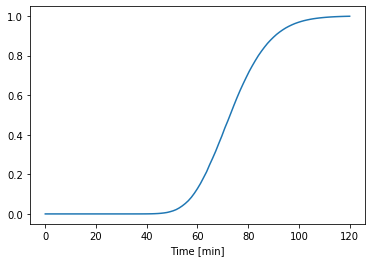

In [133]:
C_btc = conc[:, 0, 0, -1]
print(np.max(conc))
plt.plot(times/60, C_btc, label='Breakthrough Curve')
plt.xlabel('Time [min]');

## 1D Analytical Solution Function
Now lets compare the numerical results with the analytical solution we looked at in our previous notebook.

In [134]:
# Remember that we need a few special functions
from scipy.special import erfc as erfc
from scipy.special import erf as erf

# Analytical solution
def ADE_type1_Rfun(x, t, v, D, rhob, kd, phi, C0):
    R = 1 + rhob*kd/phi
    
    # Note that the '\' means continued on the next line
    C = C0*((1/2)*erfc((R*x - v*t)/(2*np.sqrt(D*R*t))) + \
        (1/2)*np.exp(v*x/D)*erfc((R*x + v*t)/(2*np.sqrt(D*R*t))))
    # Return the concentration (C) from this function
    return C

Call the function to calculate the breakthrough curve at outlet of the core

In [135]:
# Extract the model grid cell location (in selected units, cm in this case)
x = mf.dis.sr.xcenter
print('Outlet of model: ' + str(x[-1]) + ' cm')

Outlet of model: 20.10000029951334 cm


In [136]:
# Call the FloPy model function
D = v*al
C_analytical = ADE_type1_Rfun(x[-1], times, v, D, rhob, kd, prsity, 1)

Now let's plot a comparison.

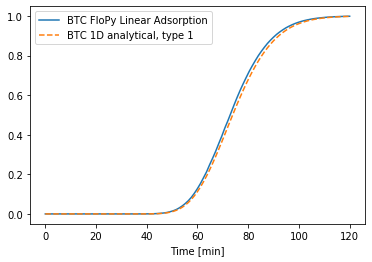

In [137]:
c1, = plt.plot(times/60, C_btc, label='BTC FloPy Linear Adsorption')
c2, = plt.plot(times/60, C_analytical, '--', label='BTC 1D analytical, type 1')
plt.xlabel('Time [min]');

plt.legend(handles=[c1, c2])

It is always a good idea to this type of numerical-analytical model comparison when you are building new numerical models or using packages that you are unfamiliar with to make sure the numerical model is performing as expected!

## Activity:
Use this model explore how the breakthrough curves for pulse injections change with different adsorption behavior.

Below are initial models for comparing conservative transport with linear, Freundlich, and Langmuir adsorption solute transport.

In [125]:
dirname = 'conserv_pulse'
perlen_mt = [60*2, 60*150]
al = 0.3 # cm

isothm = 1
kd = 0 
sp2 = 0

# Call the FloPy model function
mf, mt, times, conc = reaction_model_1D(dirname, perlen_mt, 
        prsity, v, al, isothm, rhob, kd, sp2)

C_conservative_btc = conc[:, 0, 0, -1]

.\reactions_1D_models\conserv_pulse
Model length is: 20.2 (check units of 'lenuni')


In [126]:
dirname = 'linear_pulse'
isothm = 1
kd = 0.4 
sp2 = 0


# Call the FloPy model function
mf, mt, times, conc = reaction_model_1D(dirname, perlen_mt, 
        prsity, v, al, isothm, rhob, kd, sp2)

C_linear_btc = conc[:, 0, 0, -1]

.\reactions_1D_models\linear_pulse
Model length is: 20.2 (check units of 'lenuni')


In [127]:
dirname = 'freundlich_pulse'
isothm = 2
kf = 0.2 
N = 0.7

# Call the FloPy model function
mf, mt, times, conc = reaction_model_1D(dirname, perlen_mt, 
        prsity, v, al, isothm, rhob, kf, N)

C_freund_btc = conc[:, 0, 0, -1]

.\reactions_1D_models\freundlich_pulse
Model length is: 20.2 (check units of 'lenuni')


In [128]:
dirname = 'langmuir_pulse'
isothm = 3
alpha = 2 
beta = 0.2

# Call the FloPy model function
mf, mt, times, conc = reaction_model_1D(dirname, perlen_mt, 
        prsity, v, al, isothm, rhob, alpha, beta)

C_langmuir_btc = conc[:, 0, 0, -1]

.\reactions_1D_models\langmuir_pulse
Model length is: 20.2 (check units of 'lenuni')


Before looking at the breakthrough curves it is useful to explore what these isotherms look like. Based on these differences in isotherms, what differences do you expect in the breakthrough curve behavior?

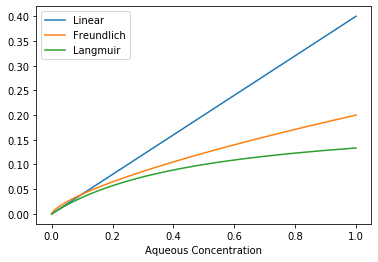

In [129]:
# Calculate Isotherms
C_iso = np.linspace(0, 1, num=200)
Cs_linear = kd*C_iso
Cs_freundlich = kf*C_iso**N
Cs_langmuir = alpha*beta*C_iso/(1+ alpha*C_iso)

# Plot the results
c1, = plt.plot(C_iso, Cs_linear, label='Linear')
c2, = plt.plot(C_iso, Cs_freundlich, label='Freundlich')
c3, = plt.plot(C_iso, Cs_langmuir, label='Langmuir')
plt.xlabel('Aqueous Concentration')
plt.legend(handles=[c1, c2, c3])

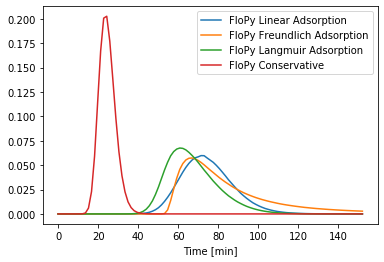

In [130]:
c1, = plt.plot(times/60, C_linear_btc, label='FloPy Linear Adsorption')
c2, = plt.plot(times/60, C_freund_btc, label='FloPy Freundlich Adsorption')
c3, = plt.plot(times/60, C_langmuir_btc, label='FloPy Langmuir Adsorption')
c4, = plt.plot(times/60, C_conservative_btc, label='FloPy Conservative')
plt.xlabel('Time [min]');

plt.legend(handles=[c1, c2, c3, c4])

Why does the Freundlich model have the longest tail? Whydoes the Langmuir model breakthrough faster than the linear or Freundlich model?

Test the breakthrough behavior for different isotherms. After playing around with different adsorption models discuss the following with a partner. How do the different models lead to skewing of the breakthrough curves? How does the steepness of the isoterm and the plateau value impact the breakthrough curve behavior?